# Setup

In [76]:
#import library

import os
import rasterio, json
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import glob
import subprocess
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask as rasterio_mask  # Alias the mask function
from rasterio.enums import Resampling
from shapely.geometry import mapping
import pandas as pd
from rasterio.windows import from_bounds
from tqdm import tqdm
from rasterio.shutil import copy as rio_copy
import tempfile
import gzip
import shutil
import matplotlib.colors as mcolors
from rasterio.warp import reproject

## Unzip land cover data

In [ ]:
landcover_base_dir  ='data/02-land-cover-data/input'

landcover_years = ["2019", "2024"]

extracted_base = os.path.join(landcover_base_dir, "unzipped")
os.makedirs(extracted_base, exist_ok=True)

for year in landcover_years:
    year_folder = os.path.join(landcover_base_dir, year)
    output_folder = os.path.join(extracted_base, year)
    os.makedirs(output_folder, exist_ok=True)

    # Find all zip files in that folder
    zip_files = [f for f in os.listdir(year_folder) if f.endswith('.zip')]
    print(f"Found {len(zip_files)} zip files in {year_folder}")

    for zip_name in zip_files:
        zip_path = os.path.join(year_folder, zip_name)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_folder)

    print(f"Extracted all {year} land cover data to: {output_folder}")

Found 326 zip files in data/02-land-cover-data/input\2019
Extracted all 2019 land cover data to: data/02-land-cover-data/input\unzipped\2019
Found 326 zip files in data/02-land-cover-data/input\2024
Extracted all 2024 land cover data to: data/02-land-cover-data/input\unzipped\2024


## Convert JP2 to tiff

In [3]:
# === Bands to extract ===
targets = ["B02", "B03", "B04", "B08", "B11"]

# Base directories
sentinel_base_dir = "data/01-sentinel"

input_dirs = {
    "2019": os.path.join(sentinel_base_dir, "2019"),
    "2024": os.path.join(sentinel_base_dir, "2024")
}

output_dirs = {
    "2019": os.path.join(sentinel_base_dir, "tif2019"),
    "2024": os.path.join(sentinel_base_dir, "tif2024")
}

# Create output folders
for year in output_dirs:
    os.makedirs(output_dirs[year], exist_ok=True)


def convert_jp2_to_tiff(jp2_file, output_folder, year):
    """Safe conversion jp2 → tif using temp file to avoid Windows locking issues."""
    
    filename = os.path.basename(jp2_file).replace(".jp2", ".tif")
    final_path = os.path.join(output_folder, filename)

    # Create temp file (same folder → safe atomic replace)
    fd, tmp_path = tempfile.mkstemp(suffix=".tif", dir=output_folder)
    os.close(fd)  # We only need the path, Rasterio will reopen it

    try:
        with rasterio.open(jp2_file) as src:
            profile = src.profile.copy()
            profile.update(driver="GTiff")

            # Write TIFF into temporary file
            with rasterio.open(tmp_path, "w", **profile) as dst:
                dst.write(src.read())

        # Replace existing TIFF atomically (no need to delete first)
        os.replace(tmp_path, final_path)

        print(f"{year} → {filename}")

    except Exception as e:
        print(f"Error converting {jp2_file}: {e}")
        if os.path.exists(tmp_path):
            os.remove(tmp_path)


# ---------------------------------------
# Convert only target bands for each year
# ---------------------------------------
for year in input_dirs:

    print(f"Processing target bands for year {year}...")

    # Find only files matching target bands (e.g., *B02_10m.jp2)
    jp2_paths = []
    for band in targets:
        pattern_10m = os.path.join(input_dirs[year], f"**/*{band}_10m.jp2")
        pattern_20m = os.path.join(input_dirs[year], f"**/*{band}_20m.jp2")

        jp2_paths += glob.glob(pattern_10m, recursive=True)
        jp2_paths += glob.glob(pattern_20m, recursive=True)

    if not jp2_paths:
        print(f"No target bands found for year {year}")
        continue

    for jp2 in jp2_paths:
        convert_jp2_to_tiff(jp2, output_dirs[year], year)

    print(f"Finished converting target bands for {year}\n")

Processing target bands for year 2019...
2019 → T52SDE_20190604T020659_B02_10m.tif
2019 → T52SDE_20190604T020659_B02_20m.tif
2019 → T52SDE_20190604T020659_B03_10m.tif
2019 → T52SDE_20190604T020659_B03_20m.tif
2019 → T52SDE_20190604T020659_B04_10m.tif
2019 → T52SDE_20190604T020659_B04_20m.tif
2019 → T52SDE_20190604T020659_B08_10m.tif
2019 → T52SDE_20190604T020659_B11_20m.tif
Finished converting target bands for 2019

Processing target bands for year 2024...
2024 → T52SDE_20240612T020701_B02_10m.tif
2024 → T52SDE_20240612T020701_B02_20m.tif
2024 → T52SDE_20240612T020701_B03_10m.tif
2024 → T52SDE_20240612T020701_B03_20m.tif
2024 → T52SDE_20240612T020701_B04_10m.tif
2024 → T52SDE_20240612T020701_B04_20m.tif
2024 → T52SDE_20240612T020701_B08_10m.tif
2024 → T52SDE_20240612T020701_B11_20m.tif
Finished converting target bands for 2024



## Administrative boundaries data

In [4]:
gadm_path = 'data/03-boundary/boundary-daegu/daegu_boundary.shp'
gdf = gpd.read_file(gadm_path)
print("=== GADM Boundary Info ===")
print("CRS:", gdf.crs)
print("Number of Polygons:", len(gdf))
print(gdf.head())

=== GADM Boundary Info ===
CRS: EPSG:4326
Number of Polygons: 1
     GID_1 GID_0      COUNTRY NAME_1                         VARNAME_1  \
0  KOR.4_1   KOR  South Korea  Daegu  Taegu|Daegu Gwang'yeogsi|Taegu-g   

       NL_NAME_1       TYPE_1          ENGTYPE_1 CC_1 HASC_1  ISO_1  \
0  대구광역시 | 大邱廣域市  Gwangyeoksi  Metropolitan City   NA  KR.TG  KR-27   

                                            geometry  
0  POLYGON ((128.45745 35.63956, 128.45743 35.639...  


## Data Dir

In [5]:
# Folder containing 2019 TIFF outputs
SENTINEL_DIR_2019 = "data/01-sentinel/tif2019"
# Folder containing 2020 TIFF outputs
SENTINEL_DIR_2024 = "data/01-sentinel/tif2024"

# Data Preprocessing

## Sentinel data

### Check resolution

#### 2019

In [6]:
def find_first(pattern):
    files = glob.glob(os.path.join(SENTINEL_DIR_2019, pattern))
    return files[0] if files else None

# Collect band paths
bands_2019 = {
    "B02": find_first("*B02*.tif"),
    "B03": find_first("*B03*.tif"),
    "B04": find_first("*B04*.tif"),
    "B08": find_first("*B08*.tif"),   # reference band
    "B11": find_first("*B11*.tif")
}

print("=== Loaded Band Paths ===")
for band, path in bands_2019.items():
    print(f"{band}: {path}")

# ------------------------------
# Inspect reference band (B08)
# ------------------------------
ref_path = bands_2019["B08"]

with rasterio.open(ref_path) as ref:
    bounds = ref.bounds
    print("\n=== Sentinel Raster Info (B08 Reference) ===")
    print("Resolution (pixel size):", ref.res)
    print("Image Size (height, width):", (ref.height, ref.width))
    print("CRS:", ref.crs)
    print("Bounds:", bounds)
    print("Number of Bands:", ref.count)
    print("Data Type:", ref.dtypes)
    print("Transform (affine):", ref.transform)

=== Loaded Band Paths ===
B02: data/01-sentinel/tif2019\T52SDE_20190604T020659_B02_10m.tif
B03: data/01-sentinel/tif2019\T52SDE_20190604T020659_B03_10m.tif
B04: data/01-sentinel/tif2019\T52SDE_20190604T020659_B04_10m.tif
B08: data/01-sentinel/tif2019\T52SDE_20190604T020659_B08_10m.tif
B11: data/01-sentinel/tif2019\T52SDE_20190604T020659_B11_20m.tif

=== Sentinel Raster Info (B08 Reference) ===
Resolution (pixel size): (10.0, 10.0)
Image Size (height, width): (10980, 10980)
CRS: EPSG:32652
Bounds: BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4000020.00|
| 0.00, 0.00, 1.00|


In [7]:
#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

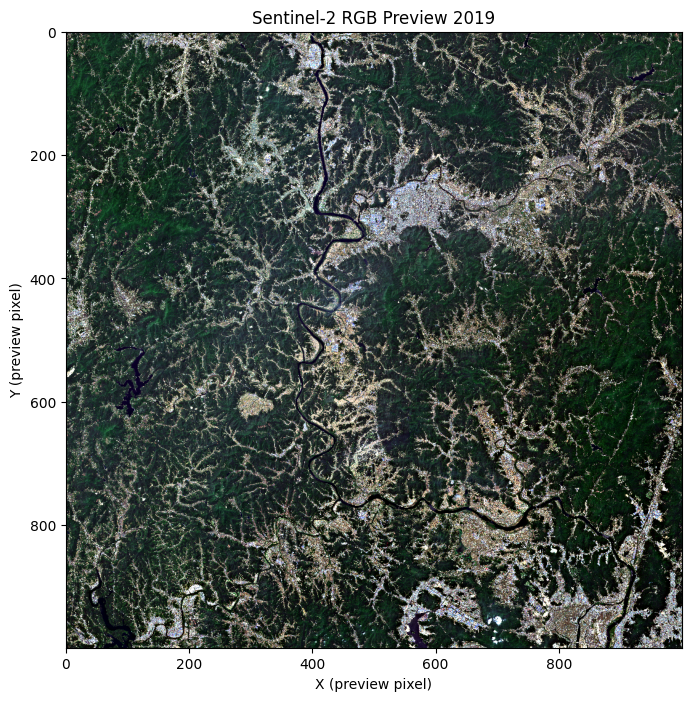

In [8]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands_2019["B04"]) as r: R2019 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2019["B03"]) as r: G2019 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2019["B02"]) as r: B2019 = r.read(1, out_shape=(scale, scale))


#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R2019), qstretch(G2019), qstretch(B2019)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2019")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("data/04-output/2019/Sentinel2_preview_2019",
            dpi=300, bbox_inches='tight')
plt.show()

#### 2024

In [9]:
def find_first(pattern):
    files = glob.glob(os.path.join(SENTINEL_DIR_2024, pattern))
    return files[0] if files else None

# Collect band paths
bands_2024 = {
    "B02": find_first("*B02*.tif"),
    "B03": find_first("*B03*.tif"),
    "B04": find_first("*B04*.tif"),
    "B08": find_first("*B08*.tif"),   # reference band
    "B11": find_first("*B11*.tif")
}

print("=== Loaded Band Paths ===")
for band, path in bands_2024.items():
    print(f"{band}: {path}")

# ------------------------------
# Inspect reference band (B08)
# ------------------------------
ref_path = bands_2024["B08"]

with rasterio.open(ref_path) as ref:
    bounds = ref.bounds
    print("\n=== Sentinel Raster Info (B08 Reference) ===")
    print("Resolution (pixel size):", ref.res)
    print("Image Size (height, width):", (ref.height, ref.width))
    print("CRS:", ref.crs)
    print("Bounds:", bounds)
    print("Number of Bands:", ref.count)
    print("Data Type:", ref.dtypes)
    print("Transform (affine):", ref.transform)

=== Loaded Band Paths ===
B02: data/01-sentinel/tif2024\T52SDE_20240612T020701_B02_10m.tif
B03: data/01-sentinel/tif2024\T52SDE_20240612T020701_B03_10m.tif
B04: data/01-sentinel/tif2024\T52SDE_20240612T020701_B04_10m.tif
B08: data/01-sentinel/tif2024\T52SDE_20240612T020701_B08_10m.tif
B11: data/01-sentinel/tif2024\T52SDE_20240612T020701_B11_20m.tif

=== Sentinel Raster Info (B08 Reference) ===
Resolution (pixel size): (10.0, 10.0)
Image Size (height, width): (10980, 10980)
CRS: EPSG:32652
Bounds: BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4000020.00|
| 0.00, 0.00, 1.00|


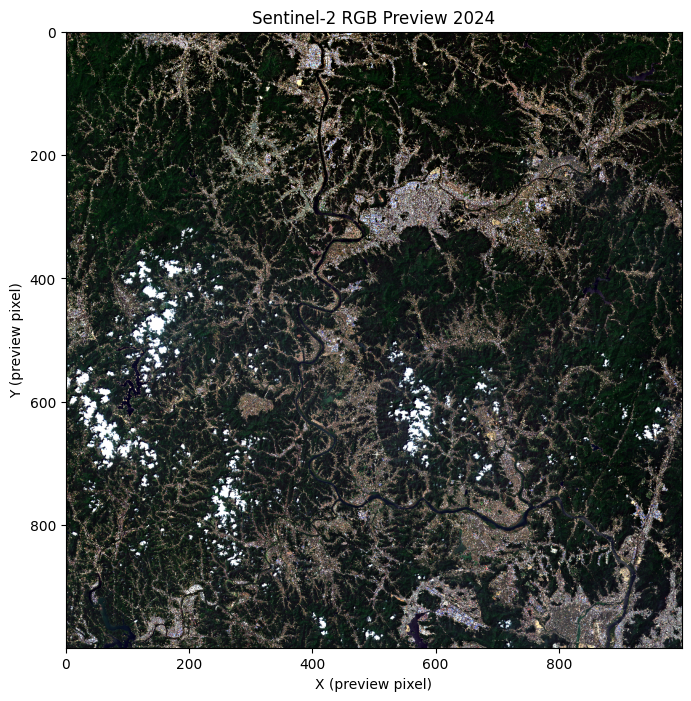

In [10]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands_2024["B04"]) as r: R2024 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2024["B03"]) as r: G2024 = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2024["B02"]) as r: B2024 = r.read(1, out_shape=(scale, scale))


#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R2024), qstretch(G2024), qstretch(B2024)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2024")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("data/04-output/2024/Sentinel2_preview_2024",
            dpi=300, bbox_inches='tight')
plt.show()

### Reprojection

sentinel raster info : EPSG:32652
GADM CRS before :  EPSG:4326
GADM CRS after :  PROJCS["WGS 84 / UTM zone 52N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32652"]]


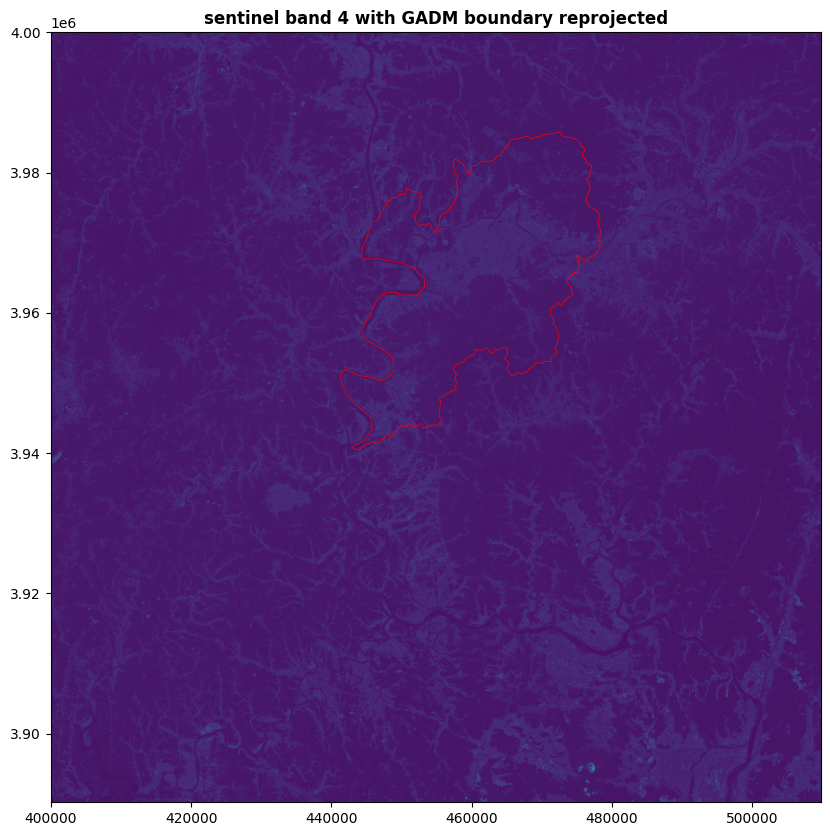

In [11]:
raster_path_B410 = 'data/01-sentinel/tif2019/T52SDE_20190604T020659_B04_10m.tif'

#open raster
raster = rasterio.open(raster_path_B410)
print('sentinel raster info :', raster.crs)
#GADM city boundary
print('GADM CRS before : ', gdf.crs)

#Reproject GADM to match the sentinel CRS
gadm_reproject = gdf.to_crs(raster.crs)
print('GADM CRS after : ', gadm_reproject.crs)

#save the reproject
gadm_reproject.to_file('data/03-boundary/boundary-daegu/daegu_boundary_reproject.shp')

#plot
fig, ax = plt.subplots(figsize=(10,10))
show(raster, ax=ax, title='sentinel band 4 with GADM boundary reprojected')
gadm_reproject.boundary.plot(ax=ax, color='red', linewidth=0.5)
plt.show()

### Clip and Masking

In [12]:
daegu_boundary = 'data/03-boundary/boundary-daegu/daegu_boundary_reproject.shp'

#### 2019

In [13]:
#path
clipped_output_dir = 'data/05_Clipped_data/2019'
os.makedirs(clipped_output_dir, exist_ok=True)

# Load the reprojected Daegu boundary and get its geometries
d_boundary = gpd.read_file(daegu_boundary)
geom = [mapping(d_boundary.geometry.squeeze())]

#list sentinel tiff
band_files = [f for f in os.listdir(SENTINEL_DIR_2019) if f.endswith('.tif')]
print('found bands:', band_files)

#loop through each band
for band in band_files:
  in_path = os.path.join(SENTINEL_DIR_2019, band)
  out_path = os.path.join(clipped_output_dir, band.replace('.tif', '_clipped.tif'))

  with rasterio.open(in_path) as src:
    out_image, out_transform = rasterio_mask(src,geom, crop=True) # Use aliased function
    out_meta = src.meta.copy()
    out_meta.update({
        'height': out_image.shape[1],
        'width': out_image.shape[2], # Corrected from 'weight' to 'width'
        'transform': out_transform
    })

    with rasterio.open(out_path, 'w', **out_meta) as dest:
      dest.write(out_image)
    print(f'clipped {band} -> saved to {out_path}')

found bands: ['T52SDE_20190604T020659_B02_10m.tif', 'T52SDE_20190604T020659_B02_20m.tif', 'T52SDE_20190604T020659_B03_10m.tif', 'T52SDE_20190604T020659_B03_20m.tif', 'T52SDE_20190604T020659_B04_10m.tif', 'T52SDE_20190604T020659_B04_20m.tif', 'T52SDE_20190604T020659_B08_10m.tif', 'T52SDE_20190604T020659_B11_20m.tif']
clipped T52SDE_20190604T020659_B02_10m.tif -> saved to data/05_Clipped_data/2019\T52SDE_20190604T020659_B02_10m_clipped.tif
clipped T52SDE_20190604T020659_B02_20m.tif -> saved to data/05_Clipped_data/2019\T52SDE_20190604T020659_B02_20m_clipped.tif
clipped T52SDE_20190604T020659_B03_10m.tif -> saved to data/05_Clipped_data/2019\T52SDE_20190604T020659_B03_10m_clipped.tif
clipped T52SDE_20190604T020659_B03_20m.tif -> saved to data/05_Clipped_data/2019\T52SDE_20190604T020659_B03_20m_clipped.tif
clipped T52SDE_20190604T020659_B04_10m.tif -> saved to data/05_Clipped_data/2019\T52SDE_20190604T020659_B04_10m_clipped.tif
clipped T52SDE_20190604T020659_B04_20m.tif -> saved to data/05

#### 2024

In [14]:
#path
clipped_output_dir = 'data/05_Clipped_data/2024'
os.makedirs(clipped_output_dir, exist_ok=True)

# Load the reprojected Daegu boundary and get its geometries
d_boundary = gpd.read_file(daegu_boundary)
geom = [mapping(d_boundary.geometry.squeeze())]

#list sentinel tiff
band_files = [f for f in os.listdir(SENTINEL_DIR_2024) if f.endswith('.tif')]
print('found bands:', band_files)

#loop through each band
for band in band_files:
  in_path = os.path.join(SENTINEL_DIR_2024, band)
  out_path = os.path.join(clipped_output_dir, band.replace('.tif', '_clipped.tif'))

  with rasterio.open(in_path) as src:
    out_image, out_transform = rasterio_mask(src,geom, crop=True) # Use aliased function
    out_meta = src.meta.copy()
    out_meta.update({
        'height': out_image.shape[1],
        'width': out_image.shape[2], # Corrected from 'weight' to 'width'
        'transform': out_transform
    })

    with rasterio.open(out_path, 'w', **out_meta) as dest:
      dest.write(out_image)
    print(f'clipped {band} -> saved to {out_path}')

found bands: ['T52SDE_20240612T020701_B02_10m.tif', 'T52SDE_20240612T020701_B02_20m.tif', 'T52SDE_20240612T020701_B03_10m.tif', 'T52SDE_20240612T020701_B03_20m.tif', 'T52SDE_20240612T020701_B04_10m.tif', 'T52SDE_20240612T020701_B04_20m.tif', 'T52SDE_20240612T020701_B08_10m.tif', 'T52SDE_20240612T020701_B11_20m.tif']
clipped T52SDE_20240612T020701_B02_10m.tif -> saved to data/05_Clipped_data/2024\T52SDE_20240612T020701_B02_10m_clipped.tif
clipped T52SDE_20240612T020701_B02_20m.tif -> saved to data/05_Clipped_data/2024\T52SDE_20240612T020701_B02_20m_clipped.tif
clipped T52SDE_20240612T020701_B03_10m.tif -> saved to data/05_Clipped_data/2024\T52SDE_20240612T020701_B03_10m_clipped.tif
clipped T52SDE_20240612T020701_B03_20m.tif -> saved to data/05_Clipped_data/2024\T52SDE_20240612T020701_B03_20m_clipped.tif
clipped T52SDE_20240612T020701_B04_10m.tif -> saved to data/05_Clipped_data/2024\T52SDE_20240612T020701_B04_10m_clipped.tif
clipped T52SDE_20240612T020701_B04_20m.tif -> saved to data/05

#### check clipped data

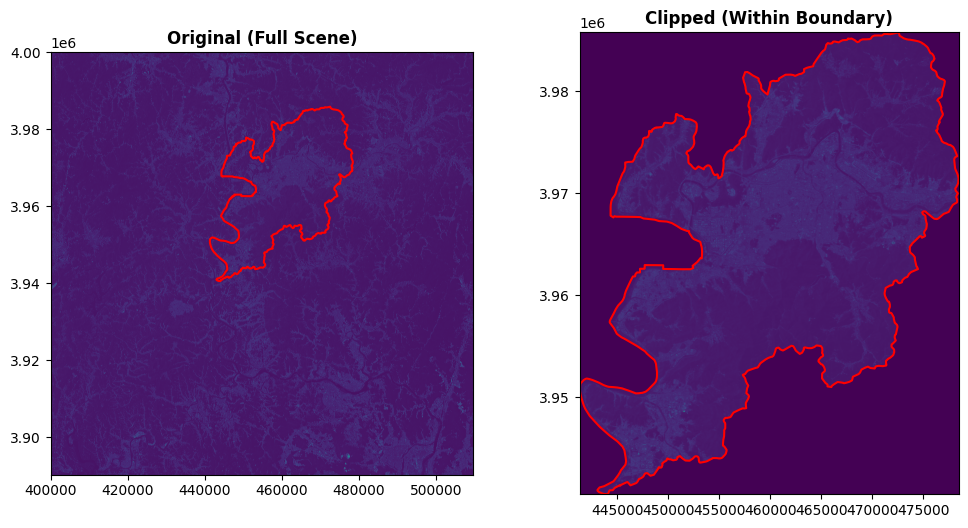

In [15]:
#path
clipped_path = 'data/05_Clipped_data/2019/T52SDE_20190604T020659_B04_10m_clipped.tif'
original_path = 'data/01-sentinel/tif2019/T52SDE_20190604T020659_B04_10m.tif'
boundary_path = 'data/03-boundary/boundary-daegu/daegu_boundary_reproject.shp'

#load
orig = rasterio.open(original_path)
clipped = rasterio.open(clipped_path)
boundary = gpd.read_file(boundary_path)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
show(orig, ax=ax1, title="Original (Full Scene)")
d_boundary.boundary.plot(ax=ax1, color='red')
show(clipped, ax=ax2, title="Clipped (Within Boundary)")
d_boundary.boundary.plot(ax=ax2, color='red')
plt.show()

In [16]:
print("Original bounds:", orig.bounds)
print("Clipped bounds :", clipped.bounds)
print("Original shape (rows, cols):", (orig.height, orig.width))
print("Clipped shape (rows, cols):", (clipped.height, clipped.width))

Original bounds: BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)
Clipped bounds : BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Original shape (rows, cols): (10980, 10980)
Clipped shape (rows, cols): (4531, 3714)


In [17]:
print("Raster CRS:", clipped.crs)
print("Boundary CRS:", d_boundary.crs)

Raster CRS: EPSG:32652
Boundary CRS: EPSG:32652


### Clipped RGB data

In [18]:
clipped_2019_dir = 'data/05_Clipped_data/2019'
clipped_2024_dir = 'data/05_Clipped_data/2024'

#### 2019

In [19]:
def find_first_2019(pattern):
    files = glob.glob(os.path.join(clipped_2019_dir, pattern))
    return files[0] if files else None

bands_2019_clipped = {
    "B02": find_first_2019("*B02*.tif"),
    "B03": find_first_2019("*B03*.tif"),
    "B04": find_first_2019("*B04*.tif"),
    "B08": find_first_2019("*B08*.tif"),
    "B11": find_first_2019("*B11*.tif")
}

#Vegetative band (B08) ---> this is for reference (to check resolution, coordinate system and bound)
ref = rasterio.open(bands_2019_clipped["B08"])
bounds = ref.bounds
print("=== Sentinel Raster info ===")
print("Original resolution:", (ref.height, ref.width))
print("CRS:", ref.crs)
print("Bounds", bounds)
print("Number of Bands:", ref.count)
print("Data Type:", ref.dtypes)
print("Transform (affine):", ref.transform)

=== Sentinel Raster info ===
Original resolution: (4531, 3714)
CRS: EPSG:32652
Bounds BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 441320.00|
| 0.00,-10.00, 3985790.00|
| 0.00, 0.00, 1.00|


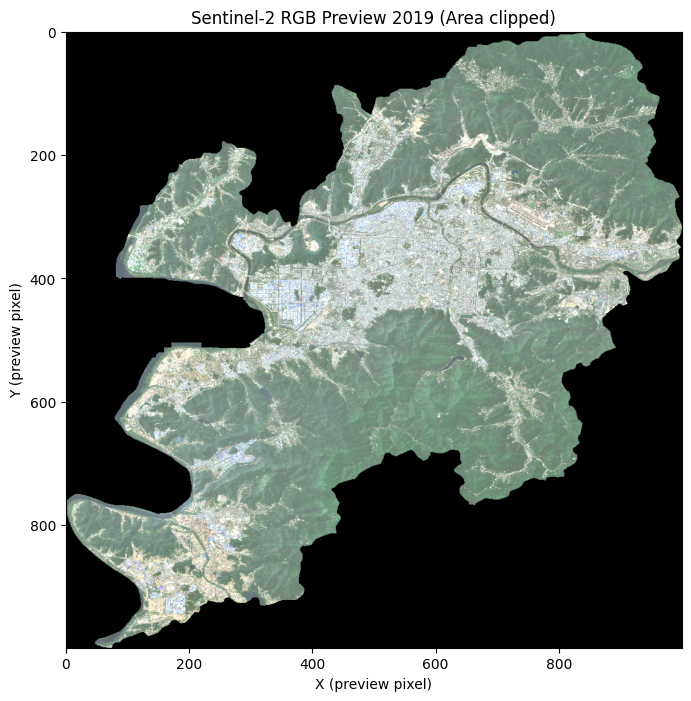

In [20]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands_2019_clipped["B04"]) as r: R2019_c = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2019_clipped["B03"]) as r: G2019_c = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2019_clipped["B02"]) as r: B2019_c = r.read(1, out_shape=(scale, scale))


#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R2019_c), qstretch(G2019_c), qstretch(B2019_c)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2019 (Area clipped)")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("data/04-output/2019/Sentinel2_preview_2019_clipped",
            dpi=300, bbox_inches='tight')
plt.show()

#### 2024

In [21]:
def find_first_2024(pattern):
    files = glob.glob(os.path.join(clipped_2024_dir, pattern))
    return files[0] if files else None

bands_2024_clipped = {
    "B02": find_first_2024("*B02*.tif"),
    "B03": find_first_2024("*B03*.tif"),
    "B04": find_first_2024("*B04*.tif"),
    "B08": find_first_2024("*B08*.tif"),
    "B11": find_first_2024("*B11*.tif")
}

#Vegetative band (B08) ---> this is for reference (to check resolution, coordinate system and bound)
ref = rasterio.open(bands_2024_clipped["B08"])
bounds = ref.bounds
print("=== Sentinel Raster info ===")
print("Original resolution:", (ref.height, ref.width))
print("CRS:", ref.crs)
print("Bounds", bounds)
print("Number of Bands:", ref.count)
print("Data Type:", ref.dtypes)
print("Transform (affine):", ref.transform)

=== Sentinel Raster info ===
Original resolution: (4531, 3714)
CRS: EPSG:32652
Bounds BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 441320.00|
| 0.00,-10.00, 3985790.00|
| 0.00, 0.00, 1.00|


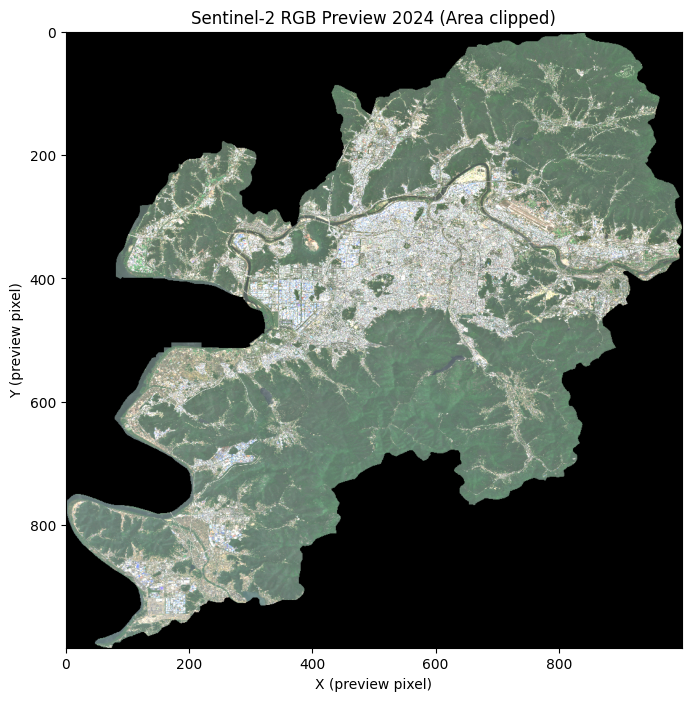

In [22]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands_2024_clipped["B04"]) as r: R2024_c = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2024_clipped["B03"]) as r: G2024_c = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands_2024_clipped["B02"]) as r: B2024_c = r.read(1, out_shape=(scale, scale))


#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R2024_c), qstretch(G2024_c), qstretch(B2024_c)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2024 (Area clipped)")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("data/04-output/2024/Sentinel2_preview_2024_clipped",
            dpi=300, bbox_inches='tight')
plt.show()

### Resampling (20M to 10M)

In [23]:
def resample_to_10m(ref_path, band_path, output_path):
    with rasterio.open(ref_path) as ref:
        ref_transform = ref.transform
        ref_width = ref.width
        ref_height = ref.height
        ref_crs = ref.crs

    with rasterio.open(band_path) as src:
        data = src.read(
            out_shape=(src.count, ref_height, ref_width),
            resampling=Resampling.bilinear
        )

        new_meta = src.meta.copy()
        new_meta.update({
            "height": ref_height,
            "width": ref_width,
            "transform": ref_transform,
            "crs": ref_crs
        })

        with rasterio.open(output_path, "w", **new_meta) as dst:
            dst.write(data)

#### 2019

In [24]:
os.makedirs('data/06_Resampled_data/', exist_ok=True)

resample_to_10m(
    ref_path='data/05_Clipped_data/2019/T52SDE_20190604T020659_B04_10m_clipped.tif',
    band_path='data/05_Clipped_data/2019/T52SDE_20190604T020659_B11_20m_clipped.tif',
    output_path='data/06_Resampled_data/B11_resampled_10m_2019.tif'
)

#### 2024

In [25]:
resample_to_10m(
    ref_path='data/05_Clipped_data/2024/T52SDE_20240612T020701_B04_10m_clipped.tif',
    band_path='data/05_Clipped_data/2024/T52SDE_20240612T020701_B11_20m_clipped.tif',
    output_path='data/06_Resampled_data/B11_resampled_10m_2024.tif'
)

In [26]:
# read resampled data
B11_masking_2019 = rasterio.open('data/06_Resampled_data/B11_resampled_10m_2019.tif')
B11_masking_2024 = rasterio.open('data/06_Resampled_data/B11_resampled_10m_2024.tif')

print("B11 2019 masked data bounds:", B11_masking_2019.bounds)
print("B11 2024 masked data bounds:", B11_masking_2024.bounds)
print("B11 2019 masked data shape (rows, cols):", (B11_masking_2019.height, B11_masking_2019.width))
print("B11 2024 masked data shape (rows, cols):", (B11_masking_2024.height, B11_masking_2024.width))
print("B11 2019 masked data bounds:", B11_masking_2019.crs)
print("B11 2024 masked data bounds:", B11_masking_2024.crs)

B11 2019 masked data bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
B11 2024 masked data bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
B11 2019 masked data shape (rows, cols): (4531, 3714)
B11 2024 masked data shape (rows, cols): (4531, 3714)
B11 2019 masked data bounds: EPSG:32652
B11 2024 masked data bounds: EPSG:32652


### Copy final data

In [27]:
import os
import shutil

# Source folders
clipped_folder = r"data/05_Clipped_data"
resampled_folder = r"data/06_Resampled_data"

# Destination
final_base = r"data/07_final-sentinel-data"

# Create final base folder
os.makedirs(final_base, exist_ok=True)

# Years to export
years = ["2019", "2024"]

# Make year folders inside final
for year in years:
    os.makedirs(os.path.join(final_base, year), exist_ok=True)

def copy_10m_from_year(src_folder, year):
    year_path = os.path.join(src_folder, year)
    if not os.path.exists(year_path):
        return
    for root, _, files in os.walk(year_path):
        for f in files:
            if "10m" in f and f.endswith(".tif"):
                src = os.path.join(root, f)
                dst = os.path.join(final_base, year, f)
                print(f"Copying: {src} -> {dst}")
                shutil.copy(src, dst)

# Copy from clipped 2019 and 2024
copy_10m_from_year(clipped_folder, "2019")
copy_10m_from_year(clipped_folder, "2024")

# If resampled has no year folders (all mixed in one place)
# → sort by filename (contains 2019 / 2024)
for f in os.listdir(resampled_folder):
    if f.endswith(".tif") and "10m" in f:
        if "2019" in f:
            shutil.copy(os.path.join(resampled_folder, f),
                        os.path.join(final_base, "2019", f))
        elif "2024" in f:
            shutil.copy(os.path.join(resampled_folder, f),
                        os.path.join(final_base, "2024", f))


Copying: data/05_Clipped_data\2019\T52SDE_20190604T020659_B02_10m_clipped.tif -> data/07_final-sentinel-data\2019\T52SDE_20190604T020659_B02_10m_clipped.tif
Copying: data/05_Clipped_data\2019\T52SDE_20190604T020659_B03_10m_clipped.tif -> data/07_final-sentinel-data\2019\T52SDE_20190604T020659_B03_10m_clipped.tif
Copying: data/05_Clipped_data\2019\T52SDE_20190604T020659_B04_10m_clipped.tif -> data/07_final-sentinel-data\2019\T52SDE_20190604T020659_B04_10m_clipped.tif
Copying: data/05_Clipped_data\2019\T52SDE_20190604T020659_B08_10m_clipped.tif -> data/07_final-sentinel-data\2019\T52SDE_20190604T020659_B08_10m_clipped.tif
Copying: data/05_Clipped_data\2024\T52SDE_20240612T020701_B02_10m_clipped.tif -> data/07_final-sentinel-data\2024\T52SDE_20240612T020701_B02_10m_clipped.tif
Copying: data/05_Clipped_data\2024\T52SDE_20240612T020701_B03_10m_clipped.tif -> data/07_final-sentinel-data\2024\T52SDE_20240612T020701_B03_10m_clipped.tif
Copying: data/05_Clipped_data\2024\T52SDE_20240612T020701_

## Land Cover Data

### Merger

In [28]:
# Base directories
lc_base_dir = 'data/02-land-cover-data/input/unzipped'
years = ['2019', '2024']

merged_output_dir = os.path.join(lc_base_dir, 'merged')
os.makedirs(merged_output_dir, exist_ok=True)

for year in years:
    year_path = os.path.join(lc_base_dir, year)
    shapefiles = glob.glob(os.path.join(year_path, '**', '*.shp'), recursive=True)
    print(f"Found {len(shapefiles)} shapefiles in {year} folder")

    # Merge all shapefiles into one GeoDataFrame
    # Only proceed if shapefiles are found
    if shapefiles:
        gdfs = [gpd.read_file(shp) for shp in shapefiles]
        merged = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

        output_path = os.path.join(merged_output_dir, f"Daegu_landcover_{year}_merged.shp")
        merged.to_file(output_path, encoding='utf-8')
        print(f"Merged {year} shapefiles saved to: {output_path}")
    else:
        print(f"No shapefiles to merge for {year}.")


Found 326 shapefiles in 2019 folder


d:\01. Convergence System Engineering\1st Semester\Energy and 3D GIS\urban-expansion\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field IMG_DATE create as date field, though DateTime requested.
  ogr_write(


Merged 2019 shapefiles saved to: data/02-land-cover-data/input/unzipped\merged\Daegu_landcover_2019_merged.shp
Found 326 shapefiles in 2024 folder


d:\01. Convergence System Engineering\1st Semester\Energy and 3D GIS\urban-expansion\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field IMG_DATE create as date field, though DateTime requested.
  ogr_write(


Merged 2024 shapefiles saved to: data/02-land-cover-data/input/unzipped\merged\Daegu_landcover_2024_merged.shp


In [29]:
merged_dir = 'data/02-land-cover-data/input/unzipped/merged'

# Load both merged shapefiles
gdf_2019 = gpd.read_file(os.path.join(merged_dir, 'Daegu_landcover_2019_merged.shp'))
gdf_2024 = gpd.read_file(os.path.join(merged_dir, 'Daegu_landcover_2024_merged.shp'))

# Print basic info
print("2019:", len(gdf_2019), "features")
print("2024:", len(gdf_2024), "features")

# Check CRS
print("2019 CRS:", gdf_2019.crs)
print("2024 CRS:", gdf_2024.crs)

# Check unique data L1
print("\n2019 L1_NAME classes:", gdf_2019['L1_NAME'].unique())
print("2024 L1_NAME classes:", gdf_2024['L1_NAME'].unique())

# Check unique data in L3
print("\n2019 L2_NAME classes:", gdf_2019['L2_NAME'].unique())
print("2024 L2_NAME classes:", gdf_2024['L2_NAME'].unique())

# Check unique data in L3
print("\n2019 L3_NAME classes:", gdf_2019['L3_NAME'].unique())
print("2024 L3_NAME classes:", gdf_2024['L3_NAME'].unique())

2019: 332700 features
2024: 923467 features
2019 CRS: PROJCS["PCS_ITRF2000_TM",GEOGCS["ITRF2000",DATUM["International_Terrestrial_Reference_Frame_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6656"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127],PARAMETER["scale_factor",1],PARAMETER["false_easting",200000],PARAMETER["false_northing",600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2024 CRS: PROJCS["PCS_ITRF2000_TM",GEOGCS["ITRF2000",DATUM["International_Terrestrial_Reference_Frame_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6656"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127],PARAMETER["scale_factor",1],PARAMETER["false_east

### Reproject land cover

### 

In [30]:
# Reproject both to match Sentinel CRS (EPSG:32652)
sentinel_crs = "EPSG:32652"
gdf_2019_utm = gdf_2019.to_crs(sentinel_crs)
gdf_2024_utm = gdf_2024.to_crs(sentinel_crs)

# Save reprojected shapefiles
output_dir = os.path.join(merged_dir, "reprojected")
os.makedirs(output_dir, exist_ok=True)

gdf_2019_utm.to_file(os.path.join(output_dir, 'Daegu_landcover_2019_reprojected.shp'))
gdf_2024_utm.to_file(os.path.join(output_dir, 'Daegu_landcover_2024_reprojected.shp'))

print("Reprojection complete, Saved in:", output_dir)

d:\01. Convergence System Engineering\1st Semester\Energy and 3D GIS\urban-expansion\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field IMG_DATE create as date field, though DateTime requested.
  ogr_write(
d:\01. Convergence System Engineering\1st Semester\Energy and 3D GIS\urban-expansion\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field IMG_DATE create as date field, though DateTime requested.
  ogr_write(


Reprojection complete, Saved in: data/02-land-cover-data/input/unzipped/merged\reprojected


In [31]:
# Your folder containing the reprojected shapefiles
reprojected_lc_dir = 'data/02-land-cover-data/input/unzipped/merged/reprojected'

gdf_2019 = gpd.read_file(os.path.join(output_dir, 'Daegu_landcover_2019_reprojected.shp'))
gdf_2024 = gpd.read_file(os.path.join(output_dir, 'Daegu_landcover_2024_reprojected.shp'))

print("2019 features:", len(gdf_2019))
print("2024 features:", len(gdf_2024))
print("CRS:", gdf_2019.crs)
print(gdf_2019.columns)

2019 features: 332700
2024 features: 923467
CRS: EPSG:32652
Index(['L1_CODE', 'L1_NAME', 'L2_CODE', 'L2_NAME', 'L3_CODE', 'L3_NAME',
       'IMG_NAME', 'IMG_DATE', 'LU_INFO', 'ETC_INFO', 'ENV_INFO', 'FOR_INFO',
       'UD_INFO', 'INX_NUM', 'geometry'],
      dtype='object')


### Visualize

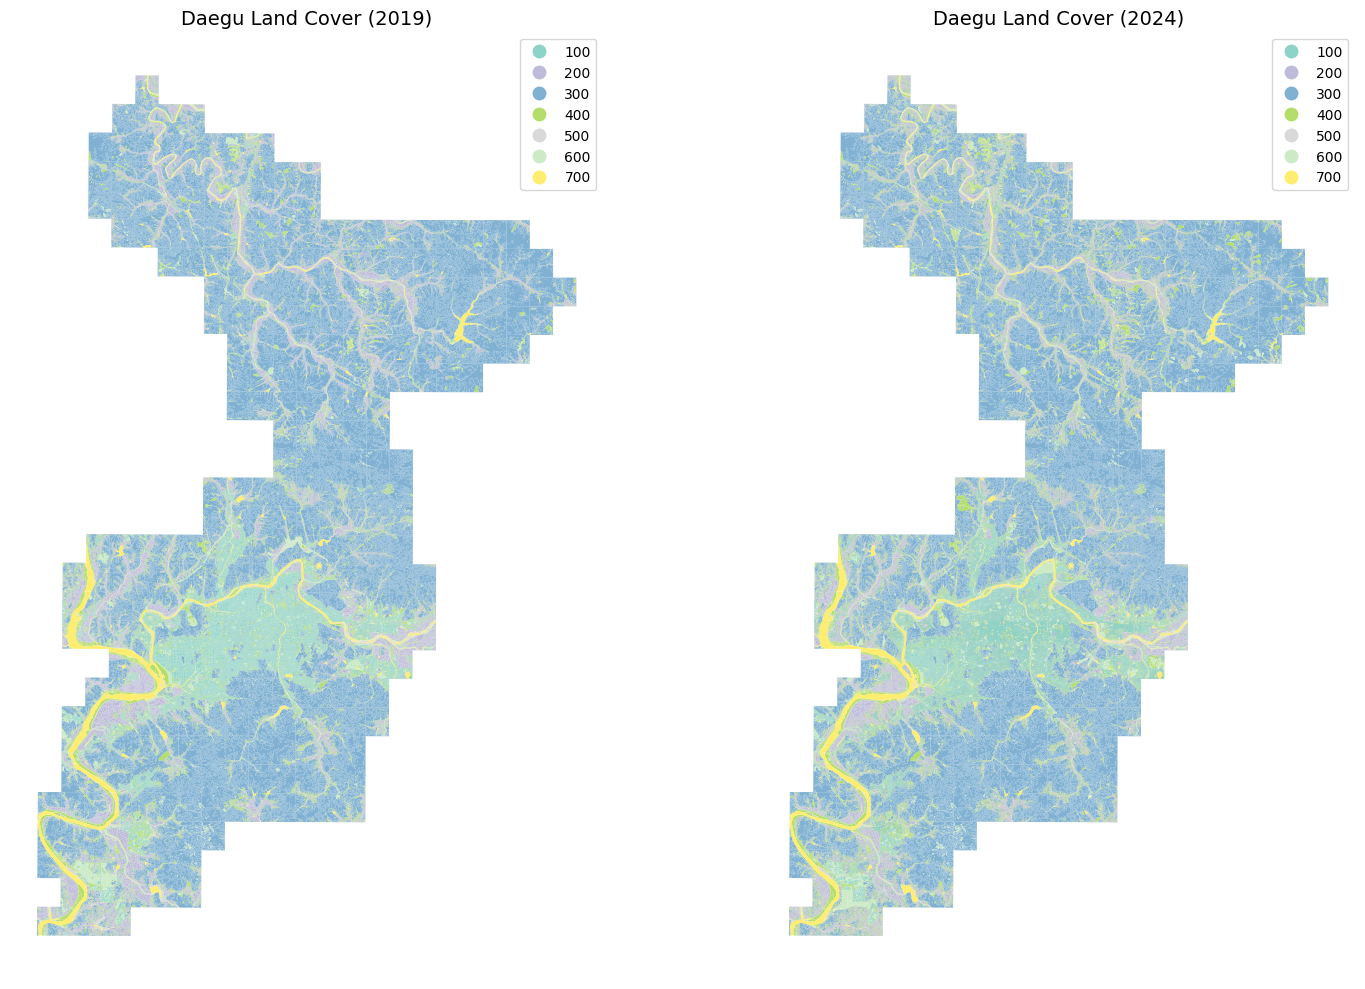

In [32]:
# Load both merged shapefiles
gdf_2019_f = gpd.read_file(os.path.join(reprojected_lc_dir, 'Daegu_landcover_2019_reprojected.shp'))
gdf_2024_f = gpd.read_file(os.path.join(reprojected_lc_dir, 'Daegu_landcover_2024_reprojected.shp'))

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

# Plot 2019
gdf_2019_f.plot(column='L1_CODE', categorical=True, legend=True, cmap='Set3', ax=ax[0])
ax[0].set_title('Daegu Land Cover (2019)', fontsize=14)
ax[0].axis('off')

# Plot 2024
gdf_2024_f.plot(column='L1_CODE', categorical=True, legend=True, cmap='Set3', ax=ax[1])
ax[1].set_title('Daegu Land Cover (2024)', fontsize=14)
ax[1].axis('off')

plt.tight_layout()
plt.show()

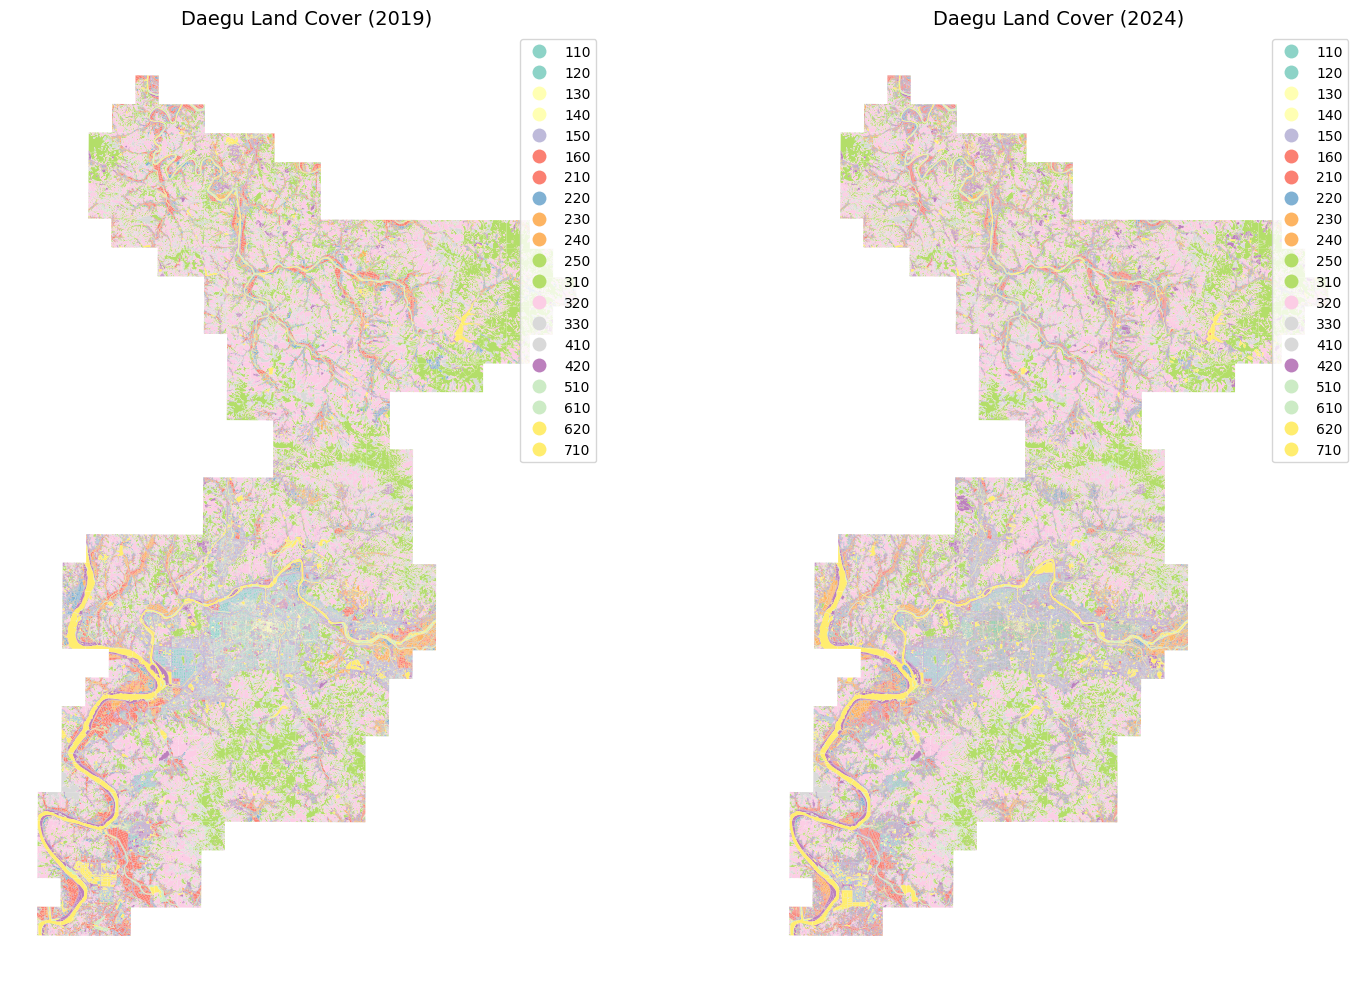

In [33]:
# Load both merged shapefiles
gdf_2019_f = gpd.read_file(os.path.join(reprojected_lc_dir, 'Daegu_landcover_2019_reprojected.shp'))
gdf_2024_f = gpd.read_file(os.path.join(reprojected_lc_dir, 'Daegu_landcover_2024_reprojected.shp'))

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

# Plot 2019
gdf_2019_f.plot(column='L2_CODE', categorical=True, legend=True, cmap='Set3', ax=ax[0])
ax[0].set_title('Daegu Land Cover (2019)', fontsize=14)
ax[0].axis('off')

# Plot 2024
gdf_2024_f.plot(column='L2_CODE', categorical=True, legend=True, cmap='Set3', ax=ax[1])
ax[1].set_title('Daegu Land Cover (2024)', fontsize=14)
ax[1].axis('off')

plt.tight_layout()
plt.show()

## DEM data

In [34]:
dem_path = 'data/08-DEM-data/DEM-DAegu-merged-clipmask.tif'

# Open DEM
with rasterio.open(dem_path) as src:
    dem = src.read(1)        # read first (and only) band
    profile = src.profile    # metadata

In [35]:
print("CRS:", profile['crs'])
print("Resolution:", profile['transform'][0])
print("Width, Height:", src.width, src.height)
print("Min, Max elevation:", dem.min(), dem.max())

CRS: EPSG:32652
Resolution: 27.9174910287199
Width, Height: 1330 1622
Min, Max elevation: 0.0 1173.9945


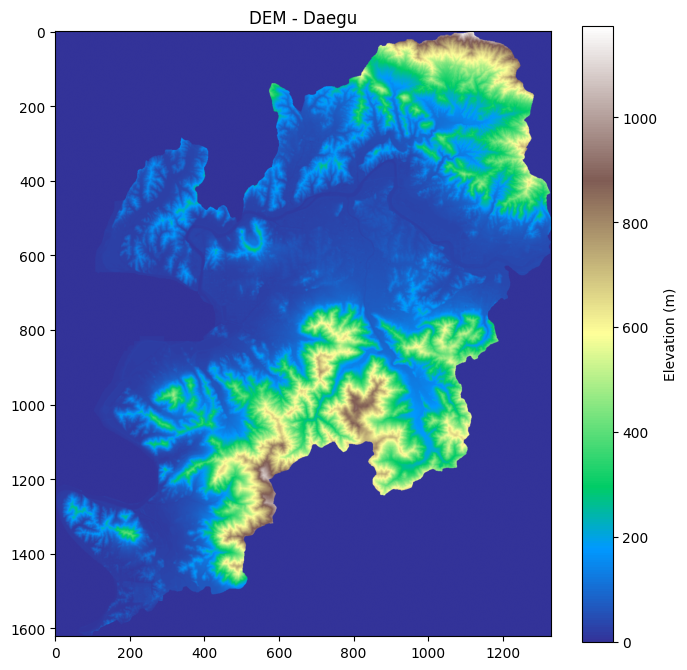

In [36]:
plt.figure(figsize=(8, 8))
plt.imshow(dem, cmap="terrain")  # "terrain", "viridis", "gist_earth", etc.
plt.colorbar(label="Elevation (m)")
plt.title("DEM - Daegu")
plt.show()


# Light night data

In [37]:
def extract_gz(input_path, output_path):
    with gzip.open(input_path, "rb") as f_in:
        with open(output_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
    print("Extracted:", output_path)

# Example
extract_gz(
    "data/10-nighttime-light-data/VNL_npp_2024_global_vcmslcfg_v2_c202502261200.average_masked.dat.tif.gz",
    "data/10-nighttime-light-data/VNL_2024.tif"
)

extract_gz(
    "data/10-nighttime-light-data/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.average_masked.dat.tif.gz",
    "data/10-nighttime-light-data/VNL_2019.tif"
)

Extracted: data/10-nighttime-light-data/VNL_2024.tif
Extracted: data/10-nighttime-light-data/VNL_2019.tif


In [43]:
vnl_path_2019 = "data/10-nighttime-light-data/VNL_2019.tif"
vnl_path_2024 = "data/10-nighttime-light-data/VNL_2024.tif"

In [41]:
d_boundary_vnl = d_boundary 
print(d_boundary_vnl.crs)

EPSG:32652


In [45]:
with rasterio.open(vnl_path_2024) as src:
    vnl_crs = src.crs

print("VNL CRS:", vnl_crs)

boundary_vnl = d_boundary_vnl.to_crs(vnl_crs)

VNL CRS: EPSG:4326


In [46]:
def clip_vnl(vnl_path, boundary_vnl, output_path):
    with rasterio.open(vnl_path) as src:
        clipped, transform = rasterio_mask(
            src, 
            boundary_vnl.geometry, 
            crop=True
        )
        
        meta = src.meta.copy()
        meta.update({
            "height": clipped.shape[1],
            "width": clipped.shape[2],
            "transform": transform
        })
    
    with rasterio.open(output_path, "w", **meta) as dst:
        dst.write(clipped)
    
    print("Saved:", output_path)
    return output_path

In [47]:
vnl_2024_path = "data/10-nighttime-light-data/VNL_2024.tif"
vnl_2024_clipped_path = "data/10-nighttime-light-data/VNL_2024_daegu_clipped.tif"

clip_vnl(vnl_2024_path, boundary_vnl, vnl_2024_clipped_path)

Saved: data/10-nighttime-light-data/VNL_2024_daegu_clipped.tif


'data/10-nighttime-light-data/VNL_2024_daegu_clipped.tif'

In [48]:
vnl_2019_path = "data/10-nighttime-light-data/VNL_2019.tif"
vnl_2019_clipped_path = "data/10-nighttime-light-data/VNL_2019_daegu_clipped.tif"

clip_vnl(vnl_2019_path, boundary_vnl, vnl_2019_clipped_path)


Saved: data/10-nighttime-light-data/VNL_2019_daegu_clipped.tif


'data/10-nighttime-light-data/VNL_2019_daegu_clipped.tif'

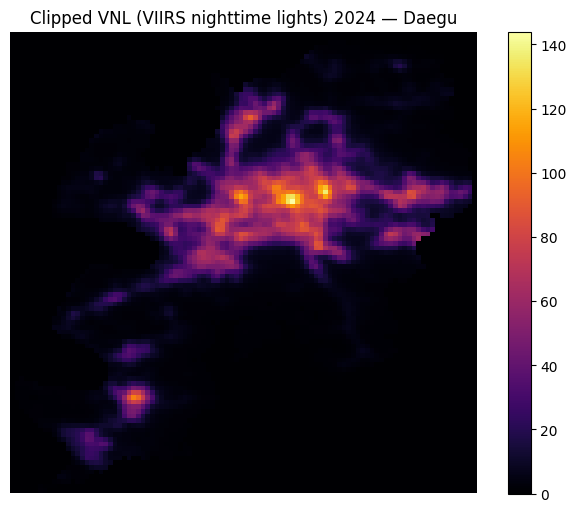

In [50]:
with rasterio.open(vnl_2024_clipped_path) as src:
    vnl2024 = src.read(1)

plt.figure(figsize=(8,6))
plt.imshow(vnl2024, cmap="inferno")
plt.title("Clipped VNL (VIIRS nighttime lights) 2024 — Daegu")
plt.axis("off")
plt.colorbar()
plt.show()

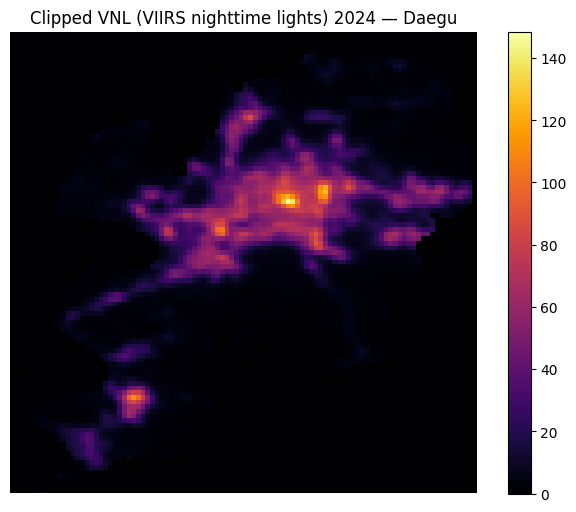

In [51]:
with rasterio.open(vnl_2019_clipped_path) as src:
    vnl2024 = src.read(1)

plt.figure(figsize=(8,6))
plt.imshow(vnl2024, cmap="inferno")
plt.title("Clipped VNL (VIIRS nighttime lights) 2024 — Daegu")
plt.axis("off")
plt.colorbar()
plt.show()

In [ ]:
# Your file paths
out_path = "data/10-nighttime-light-data/vnl_change_2019_2024.tif"

# Read both rasters
with rasterio.open(vnl_2024_clipped_path) as src24:
    vnl_2024 = src24.read(1).astype("float32")
    meta = src24.meta.copy()   # save metadata

with rasterio.open(vnl_2019_clipped_path) as src19:
    vnl_2019 = src19.read(1).astype("float32")

# Compute difference
vnl_change = vnl_2024 - vnl_2019


In [61]:
vnl_change = np.where(np.isfinite(vnl_change), vnl_change, np.nan)

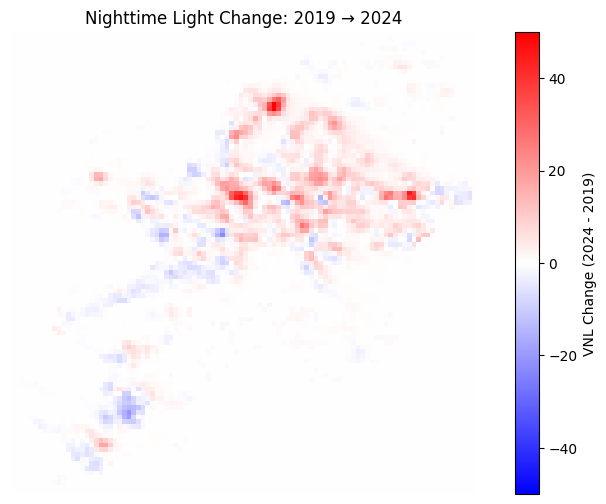

In [66]:
plt.figure(figsize=(10,6))
plt.imshow(vnl_change, cmap="bwr", vmin=-50, vmax=50)
plt.colorbar(label="VNL Change (2024 - 2019)")
plt.title("Nighttime Light Change: 2019 → 2024")
plt.axis("off")
plt.show()


## Ecological data

In [57]:
env_assess_2019 = "data/11-ecological-data/env-assessment-data-2019.tif"
env_assess_2024 = "data/11-ecological-data/env-assessment-data-2024.tif"

In [58]:
with rasterio.open(env_assess_2019) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Transform:", src.transform)
    print("Width x Height:", src.width, "x", src.height)
    print("Resolution:", src.res)
    print("Data Type:", src.dtypes)
    print("Count (bands):", src.count)

CRS: EPSG:5186
Bounds: BoundingBox(left=322319.99999999907, bottom=335270.0000000013, right=359159.99999999907, top=381170.0000000013)
Transform: | 10.00, 0.00, 322320.00|
| 0.00,-10.00, 381170.00|
| 0.00, 0.00, 1.00|
Width x Height: 3684 x 4590
Resolution: (10.0, 10.0)
Data Type: ('uint8',)
Count (bands): 1


In [59]:
with rasterio.open(env_assess_2024) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Transform:", src.transform)
    print("Width x Height:", src.width, "x", src.height)
    print("Resolution:", src.res)
    print("Data Type:", src.dtypes)
    print("Count (bands):", src.count)

CRS: EPSG:5186
Bounds: BoundingBox(left=322320.0, bottom=335270.0, right=359160.0, top=381170.0)
Transform: | 5.00, 0.00, 322320.00|
| 0.00,-5.00, 381170.00|
| 0.00, 0.00, 1.00|
Width x Height: 7368 x 9180
Resolution: (5.0, 5.0)
Data Type: ('uint8',)
Count (bands): 1


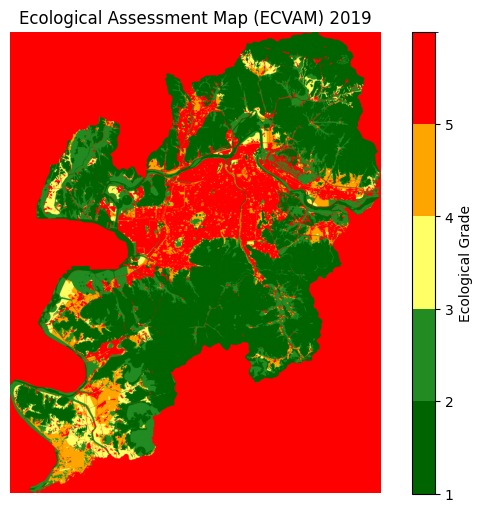

In [ ]:
# Load raster
with rasterio.open(env_assess_2019) as src:
    env2019 = src.read(1)

# Define ECVAL color scheme (1–5 grades)
cmap = mcolors.ListedColormap([
    "#006400",  # Grade 1 - dark green
    "#228B22",  # Grade 2 - green
    "#FFFF66",  # Grade 3 - yellow
    "#FFA500",  # Grade 4 - orange
    "#FF0000",  # Grade 5 - red
])
# Boundaries between grades
bounds = [1, 2, 3, 4, 5, 6]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(8,6))
plt.imshow(env2019, cmap=cmap, norm=norm)
plt.title("National Environmental Suitability Assessment Map 2019")
plt.axis("off")
plt.colorbar(ticks=[1,2,3,4,5], label="Ecological Grade")
plt.show()

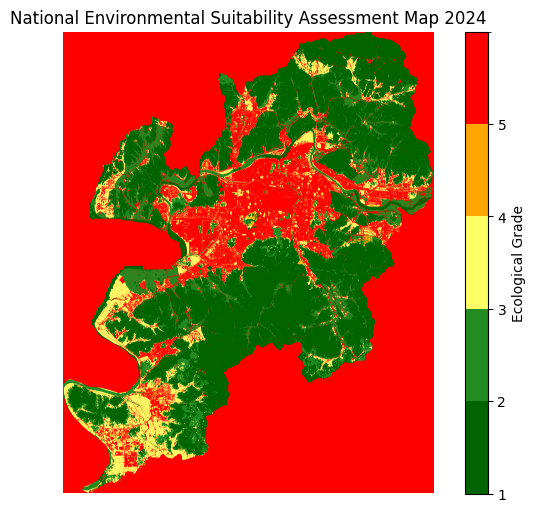

In [71]:
# Load raster
with rasterio.open(env_assess_2024) as src:
    env2024 = src.read(1)

# Define ECVAL color scheme (1–5 grades)
cmap = mcolors.ListedColormap([
    "#006400",  # Grade 1 - dark green
    "#228B22",  # Grade 2 - green
    "#FFFF66",  # Grade 3 - yellow
    "#FFA500",  # Grade 4 - orange
    "#FF0000",  # Grade 5 - red
])

# Boundaries between grades
bounds = [1, 2, 3, 4, 5, 6]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(8,6))
plt.imshow(env2024, cmap=cmap, norm=norm)
plt.title("National Environmental Suitability Assessment Map 2024")
plt.axis("off")
plt.colorbar(ticks=[1,2,3,4,5], label="Ecological Grade")
plt.show()